## Exploratory data analysis of Brazil Olist E-Commerce Data

## To do
Calculate top-level KPIs:
- KPI 1: Delivery Time vs Review Score
- KPI 2: Month-over-month (MoM) Revenue Growth
- KPI 3: Cohor Retention

## ETL

In [1]:
# import libraries
import pandas as pd
import datetime 
import numpy as np
from sqlalchemy import create_engine
import logging
import os

In [2]:
logging.basicConfig(format='%(levelname)s: %(message)s', level=logging.DEBUG)

# Create different types of logs
logging.warning("Unexpected number of rows detected.")
logging.error("{ke} arose in execution.")

ERROR: {ke} arose in execution.


In [3]:
# Connecting postgresql
postgkey = os.getenv('postglink')
connection_link = postgkey
engine = create_engine(connection_link)

# Check connection
try:
    connection = engine.connect()
    print("Connection to PostgreSQL established successfully")
except Exception as e:
    print(f"Connection failed! Error: {e}")

Connection to PostgreSQL established successfully


In [4]:
# Read data

query = "SELECT * FROM dim_customers"
customer_data = pd.read_sql(query, connection)

print(customer_data)

                            customer_id  total_spend  order_count  \
0      252c6185f3c1f1fa5a201249fd902885       157.32            3   
1      282e51b682bb8fb8064457522df17882        66.67            1   
2      09033cfedb9bab5c54a33f339fd94ad0       115.86            1   
3      60a13661d952a5128a7c81ea31e54727       314.68            1   
4      42d4a2e8a460728da550948367a9f2d9       207.20            1   
...                                 ...          ...          ...   
99435  b46ec2f0ca57df3f1300fd71d9b3ac50       107.78            1   
99436  97017b21b91c3f6d661ccaceee407af9        79.46            1   
99437  72680b3da61c269ad2e5d342356fec77      1250.81            1   
99438  8baf5c99074e0862f7cc7b09db517026       192.42            1   
99439  83a7d95a92656e2033852b2a8bb37e70        67.36            1   

      last_order_date  days_since_last_order  average_order_value  
0          2017-09-13                   3007            52.439999  
1          2017-04-03              

In [5]:
def transform(raw_data):
    return raw_data.loc[raw_data['total_spend'] > 300, :]


try:
    # Attempt to transform DataFrame, log an info-level message
    clean_order_data = transform(customer_data)
    logging.info("Successfully filtered DataFrame by 'total spend'")

except:
    # Log a warning-level message
    logging.warning("Cannot filter DataFrame by 'total spend'")

In [6]:
# Check data available in postgres database
loaded_data = pd.read_sql("SELECT * FROM dim_customers", con=engine)
print(loaded_data.shape)

(99440, 6)


In [7]:
# Print head of data
print(loaded_data.head())

                        customer_id  total_spend  order_count last_order_date  \
0  252c6185f3c1f1fa5a201249fd902885       157.32            3      2017-09-13   
1  282e51b682bb8fb8064457522df17882        66.67            1      2017-04-03   
2  09033cfedb9bab5c54a33f339fd94ad0       115.86            1      2018-08-07   
3  60a13661d952a5128a7c81ea31e54727       314.68            1      2018-03-01   
4  42d4a2e8a460728da550948367a9f2d9       207.20            1      2018-03-06   

   days_since_last_order  average_order_value  
0                   3007            52.439999  
1                   3170            66.669998  
2                   2679           115.860001  
3                   2838           314.679993  
4                   2833           207.199997  


In [7]:
# Null values
loaded_data.isnull().sum()

customer_id              0
total_spend              0
order_count              0
last_order_date          0
days_since_last_order    0
average_order_value      0
dtype: int64

## KPI1 - Delivery Time vs Review Score

In [8]:
# load review dataset
dfr = pd.read_csv('data\olist_order_reviews_dataset.csv')

dfr.head()

<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
C:\Users\user\AppData\Local\Temp\ipykernel_66752\3530972917.py:2: SyntaxWarning: invalid escape sequence '\o'
  dfr = pd.read_csv('data\olist_order_reviews_dataset.csv')


,review_id,order_id,review_score,review_comment_title,review_comment_message,review_creation_date,review_answer_timestamp
0,7bc2406110b926393aa56f80a40eba40,73fc7af87114b39712e6da79b0a377eb,4,NaN,NaN,2018-01-18 00:00:00,2018-01-18 21:46:59
1,80e641a11e56f04c1ad469d5645fdfde,a548910a1c6147796b98fdf73dbeba33,5,NaN,NaN,2018-03-10 00:00:00,2018-03-11 03:05:13
2,228ce5500dc1d8e020d8d1322874b6f0,f9e4b658b201a9f2ecdecbb34bed034b,5,NaN,NaN,2018-02-17 00:00:00,2018-02-18 14:36:24
3,e64fb393e7b32834bb789ff8bb30750e,658677c97b385a9be170737859d3511b,5,NaN,Recebi bem antes do prazo estipulado.,2017-04-21 00:00:00,2017-04-21 22:02:06
4,f7c4243c7fe1938f181bec41a392bdeb,8e6bfb81e283fa7e4f11123a3fb894f1,5,NaN,Parabéns lojas lannister adorei comprar pela I...,2018-03-01 00:00:00,2018-03-02 10:26:53


In [9]:
# Filter review dataset columns
review_data = dfr[['order_id', 'review_score', 'review_creation_date']]

In [10]:
# Load orders
orders = pd.read_csv('data\olist_orders_dataset.csv', usecols=['order_id', 'customer_id', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date'])
orders

<>:2: SyntaxWarning: invalid escape sequence '\o'
<>:2: SyntaxWarning: invalid escape sequence '\o'
C:\Users\user\AppData\Local\Temp\ipykernel_66752\3489220183.py:2: SyntaxWarning: invalid escape sequence '\o'
  orders = pd.read_csv('data\olist_orders_dataset.csv', usecols=['order_id', 'customer_id', 'order_purchase_timestamp', 'order_approved_at', 'order_delivered_customer_date', 'order_estimated_delivery_date'])


,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26 00:00:00
...,...,...,...,...,...,...
99436,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-17 15:08:01,2017-03-28 00:00:00
99437,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-28 17:37:56,2018-03-02 00:00:00
99438,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-09-21 11:24:17,2017-09-27 00:00:00
99439,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-25 23:32:54,2018-02-15 00:00:00


In [11]:
# Merging dataset reviews with orders
order_review = orders.merge(review_data, on='order_id')
order_review.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_creation_date
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,4,2017-10-11 00:00:00
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,4,2018-08-08 00:00:00
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00,5,2018-08-18 00:00:00
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15 00:00:00,5,2017-12-03 00:00:00
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26 00:00:00,5,2018-02-17 00:00:00


In [12]:
# Check datatype
order_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype 
---  ------                         --------------  ----- 
 0   order_id                       99224 non-null  object
 1   customer_id                    99224 non-null  object
 2   order_purchase_timestamp       99224 non-null  object
 3   order_approved_at              99068 non-null  object
 4   order_delivered_customer_date  96359 non-null  object
 5   order_estimated_delivery_date  99224 non-null  object
 6   review_score                   99224 non-null  int64 
 7   review_creation_date           99224 non-null  object
dtypes: int64(1), object(7)
memory usage: 6.1+ MB


In [13]:
# Transform date data
order_review['order_purchase_timestamp'] = pd.to_datetime(order_review['order_purchase_timestamp'])
order_review['order_delivered_customer_date'] = pd.to_datetime(order_review['order_delivered_customer_date'])
order_review['order_approved_at'] = pd.to_datetime(order_review['order_approved_at'])
order_review['order_estimated_delivery_date'] = pd.to_datetime(order_review['order_estimated_delivery_date'])
order_review['review_creation_date'] = pd.to_datetime(order_review['review_creation_date'])

In [14]:
# Check tranformed date data
order_review.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99224 entries, 0 to 99223
Data columns (total 8 columns):
 #   Column                         Non-Null Count  Dtype         
---  ------                         --------------  -----         
 0   order_id                       99224 non-null  object        
 1   customer_id                    99224 non-null  object        
 2   order_purchase_timestamp       99224 non-null  datetime64[ns]
 3   order_approved_at              99068 non-null  datetime64[ns]
 4   order_delivered_customer_date  96359 non-null  datetime64[ns]
 5   order_estimated_delivery_date  99224 non-null  datetime64[ns]
 6   review_score                   99224 non-null  int64         
 7   review_creation_date           99224 non-null  datetime64[ns]
dtypes: datetime64[ns](5), int64(1), object(2)
memory usage: 6.1+ MB


In [15]:
# Check null values
order_review.isnull().sum()

order_id                            0
customer_id                         0
order_purchase_timestamp            0
order_approved_at                 156
order_delivered_customer_date    2865
order_estimated_delivery_date       0
review_score                        0
review_creation_date                0
dtype: int64

In [16]:
# Average customer rating
avg_score = order_review['review_score'].mean()
med_score = order_review['review_score'].median()

print(f"Average customer review score is {avg_score}")
print(f"Median customer review score is {med_score}")

Average customer review score is 4.08642062404257
Median customer review score is 5.0


In [17]:
# Calculate delivery time deltas
order_review['actual_delivery_time'] = order_review['order_delivered_customer_date'] - order_review['order_purchase_timestamp']
order_review['delivery_performance'] = order_review['order_delivered_customer_date'] - order_review['order_estimated_delivery_date']

# Convert timedelta to days for easier analysis
order_review['delivery_days'] = order_review['actual_delivery_time'].dt.days
order_review['performance_days'] = order_review['delivery_performance'].dt.days # Negative means early, positive means late

In [18]:
# highlight late orders

late = order_review[order_review['performance_days'] > 0]
late

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_creation_date,actual_delivery_time,delivery_performance,delivery_days,performance_days
19,203096f03d82e0dffbc41ebc2e2bcfb7,d2b091571da224a1b36412c18bc3bbfe,2017-09-18 14:31:30,2017-09-19 04:04:09,2017-10-09 22:23:46,2017-09-28,2,2017-10-01,21 days 07:52:16,11 days 22:23:46,21.0,11.0
24,fbf9ac61453ac646ce8ad9783d7d0af6,3a874b4d4c4b6543206ff5d89287f0c3,2018-02-20 23:46:53,2018-02-22 02:30:46,2018-03-21 22:03:54,2018-03-12,2,2018-03-16,28 days 22:17:01,9 days 22:03:54,28.0,9.0
40,6ea2f835b4556291ffdc53fa0b3b95e8,c7340080e394356141681bd4c9b8fe31,2017-11-24 21:27:48,2017-11-25 00:21:09,2017-12-28 18:59:23,2017-12-21,1,2017-12-22,33 days 21:31:35,7 days 18:59:23,33.0,7.0
56,66e4624ae69e7dc89bd50222b59f581f,684fa6da5134b9e4dab731e00011712d,2018-03-09 14:50:15,2018-03-09 15:40:39,2018-04-03 13:28:46,2018-04-02,1,2018-04-04,24 days 22:38:31,1 days 13:28:46,24.0,1.0
57,a685d016c8a26f71a0bb67821070e398,911e4c37f5cafe1604fe6767034bf1ae,2017-03-13 18:14:36,2017-03-13 18:14:36,2017-04-06 13:37:16,2017-03-30,1,2017-04-02,23 days 19:22:40,7 days 13:37:16,23.0,7.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99179,b3112ca67f3afd4e20cf2ee91fc4f804,6f83c71b6c044fb156d697d4130fe9b5,2018-08-02 22:46:54,2018-08-02 23:04:06,2018-08-21 00:03:26,2018-08-16,2,2018-08-18,18 days 01:16:32,5 days 00:03:26,18.0,5.0
99180,0fa1fab1d7c1211c824596ed5e111e3c,7f3bd6c94d2daf7b6462d1a894a775b4,2018-03-13 21:48:57,2018-03-13 22:40:28,2018-04-05 19:59:49,2018-04-02,1,2018-04-04,22 days 22:10:52,3 days 19:59:49,22.0,3.0
99206,38e9133ce29f6bbe35aed9c3863dce01,ad312389a098ceff46ce92c4595c06d0,2017-10-12 20:54:11,2017-10-14 03:28:24,2017-11-21 17:06:59,2017-10-31,1,2017-11-03,39 days 20:12:48,21 days 17:06:59,39.0,21.0
99208,d692ef54145c9cb3322ec2e5508aa3f4,82ddfcf9438b0cd1117b55ac33184df8,2018-03-21 19:47:18,2018-03-21 20:05:26,2018-04-11 00:48:31,2018-04-09,1,2018-04-11,20 days 05:01:13,2 days 00:48:31,20.0,2.0


In [19]:
# Correlation matrix
correlation_matrix = order_review[['delivery_days', 'review_score', 'performance_days']]
print(correlation_matrix['review_score'])

0        4
1        4
2        5
3        5
4        5
        ..
99219    5
99220    4
99221    5
99222    2
99223    5
Name: review_score, Length: 99224, dtype: int64


In [20]:
# Preparing for calcuation
total_data = len(order_review)
avg_del = order_review['delivery_performance'].mean()
late_del = len(order_review[order_review['performance_days'] > 0])
late_perc = (late_del/total_data)*100


# Average products delivery time
print(f"Average delivery time: {avg_del}")

# Number of late delivery
print(f"The number of items that did not deliver on time: {late_del}")

# Percentage of late items out of total delivery
print(f"Percentage of items delivered late: {round(late_perc, 2)}%")


Average delivery time: -12 days +18:43:11.575971109
The number of items that did not deliver on time: 6410
Percentage of items delivered late: 6.46%


In [21]:
# Preparing for calculation
on_del = len(order_review[order_review['performance_days'] < 0])
on_perc = (on_del/total_data)*100

# Number of on time delivery
print(f"Number of items delivered on time: {on_del}")
print(f"Percentage of items delivered on time: {round(on_perc, 2)}%")

Number of items delivered on time: 88658
Percentage of items delivered on time: 89.35%


In [22]:
# Drop missing rows
order_review_clean = order_review.dropna()
order_review_clean

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,review_score,review_creation_date,actual_delivery_time,delivery_performance,delivery_days,performance_days
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,4,2017-10-11,8 days 10:28:40,-8 days +21:25:13,8.0,-8.0
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,4,2018-08-08,13 days 18:46:08,-6 days +15:27:45,13.0,-6.0
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04,5,2018-08-18,9 days 09:27:40,-18 days +18:06:29,9.0,-18.0
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,2017-11-18 19:28:06,2017-11-18 19:45:59,2017-12-02 00:28:42,2017-12-15,5,2017-12-03,13 days 05:00:36,-13 days +00:28:42,13.0,-13.0
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,2018-02-13 21:18:39,2018-02-13 22:20:29,2018-02-16 18:17:02,2018-02-26,5,2018-02-17,2 days 20:58:23,-10 days +18:17:02,2.0,-10.0
...,...,...,...,...,...,...,...,...,...,...,...,...
99219,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-17 15:08:01,2017-03-28,5,2017-03-22,8 days 05:13:56,-11 days +15:08:01,8.0,-11.0
99220,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-28 17:37:56,2018-03-02,4,2018-03-01,22 days 04:38:58,-2 days +17:37:56,22.0,-2.0
99221,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-09-21 11:24:17,2017-09-27,5,2017-09-22,24 days 20:37:34,-6 days +11:24:17,24.0,-6.0
99222,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-25 23:32:54,2018-02-15,2,2018-01-26,17 days 02:04:27,-21 days +23:32:54,17.0,-21.0


In [23]:
# Calculate delivery time deltas
order_review_clean['actual_delivery_time'] = order_review_clean['order_delivered_customer_date'] - order_review_clean['order_purchase_timestamp']
order_review_clean['delivery_performance'] = order_review_clean['order_delivered_customer_date'] - order_review_clean['order_estimated_delivery_date']

# Convert timedelta to days for easier analysis
order_review_clean['delivery_days'] = order_review_clean['actual_delivery_time'].dt.days
order_review_clean['performance_days'] = order_review_clean['delivery_performance'].dt.days # Negative means early, positive means late

C:\Users\user\AppData\Local\Temp\ipykernel_66752\2653380654.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_review_clean['actual_delivery_time'] = order_review_clean['order_delivered_customer_date'] - order_review_clean['order_purchase_timestamp']
C:\Users\user\AppData\Local\Temp\ipykernel_66752\2653380654.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_review_clean['delivery_performance'] = order_review_clean['order_delivered_customer_date'] - order_review_clean['order_estimated_deliver

C:\Users\user\AppData\Local\Temp\ipykernel_66752\420365346.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  order_review_clean['performance_days'] = order_review_clean['performance_days'].astype(int)
C:\Users\user\AppData\Local\Temp\ipykernel_66752\420365346.py:8: FutureWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  perc_one_del = order_review_clean.groupby('performance_days').apply(lambda x: (x['review_score']<2).mean() * 100).reset_index(name='percentage_one_star'

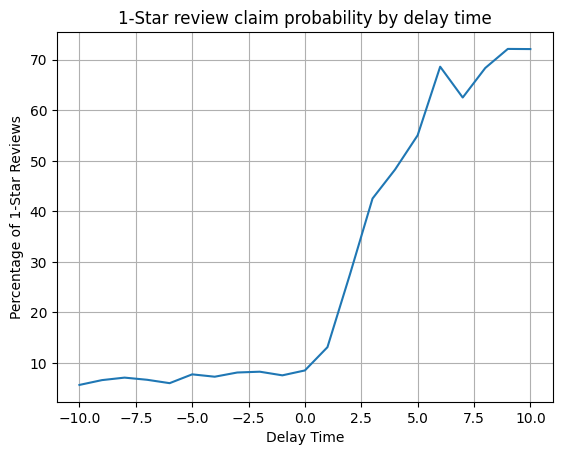

In [24]:
import matplotlib.pyplot as plt
# Percentage of one star reviews
one_star = order_review_clean[order_review_clean['review_score'] == 1]
one_perc = ((len(one_star)) / total_data) * 100

order_review_clean['performance_days'] = order_review_clean['performance_days'].astype(int)

perc_one_del = order_review_clean.groupby('performance_days').apply(lambda x: (x['review_score']<2).mean() * 100).reset_index(name='percentage_one_star')

graph_data = perc_one_del[(perc_one_del['performance_days'] >= -10) & (perc_one_del['performance_days'] <= 10)]

# Plot
plt.plot(graph_data['performance_days'], graph_data['percentage_one_star'])
plt.xlabel('Delay Time')
plt.ylabel('Percentage of 1-Star Reviews')
plt.title('1-Star review claim probability by delay time')
plt.grid(True)
plt.show()

## Analysis
Percentage of 1 star review rises after 2.5 days and then after 5 days of delay the percentage of 1 star review claim spikes up to 55%

## Delivery analysis

In [25]:
# Load olist_orders
olist_orders = pd.read_sql("SELECT * FROM olist_orders", con=engine)
print(olist_orders.shape)

# Load olist_order_reviews
olist_order_reviews = pd.read_sql("SELECT * FROM olist_order_reviews", con=engine)
print(olist_order_reviews.shape)

(99441, 8)
(99224, 7)


In [ ]:
SELECT 
	(o.order_delivered_customer_date - o.order_purchase_timestamp) AS delivery_time_in_days,
	ROUND(AVG(r.review_score), 2) AS average_review_score,
	COUNT(*) AS number_of_reviews
FROM olist_orders AS o
JOIN olist_order_reviews AS r
ON o.order_id = r.order_id
WHERE o.order_status = 'delivered'
GROUP BY delivery_time_in_days
ORDER BY delivery_time_in_days, average_review_score
;

## KPI 2 - Month-over-month revenue growth

In [26]:
# Select order_payments
payment_data = pd.read_sql("SELECT * FROM olist_order_payments", con=engine)
print(payment_data.shape)



(103886, 5)


In [27]:
# Merging dataset payments with orders
order_payment = orders.merge(payment_data, on='order_id')
order_payment.head()

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00,1,credit_card,3,179.12


In [28]:
# Check for null
order_payment.isnull().sum()

order_id                            0
customer_id                         0
order_purchase_timestamp            0
order_approved_at                 175
order_delivered_customer_date    3132
order_estimated_delivery_date       0
payment_sequential                  0
payment_type                        0
payment_installments                0
payment_value                       0
dtype: int64

In [29]:
# Drop rows with null values
order_payment = order_payment.dropna()
order_payment

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18 00:00:00,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13 00:00:00,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04 00:00:00,1,credit_card,3,179.12
...,...,...,...,...,...,...,...,...,...,...
103881,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-17 15:08:01,2017-03-28 00:00:00,1,credit_card,3,85.08
103882,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-28 17:37:56,2018-03-02 00:00:00,1,credit_card,3,195.00
103883,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-09-21 11:24:17,2017-09-27 00:00:00,1,credit_card,5,271.01
103884,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-25 23:32:54,2018-02-15 00:00:00,1,credit_card,4,441.16


In [30]:
order_payment.info()

<class 'pandas.core.frame.DataFrame'>
Index: 100740 entries, 0 to 103885
Data columns (total 10 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       100740 non-null  object 
 1   customer_id                    100740 non-null  object 
 2   order_purchase_timestamp       100740 non-null  object 
 3   order_approved_at              100740 non-null  object 
 4   order_delivered_customer_date  100740 non-null  object 
 5   order_estimated_delivery_date  100740 non-null  object 
 6   payment_sequential             100740 non-null  int64  
 7   payment_type                   100740 non-null  object 
 8   payment_installments           100740 non-null  int64  
 9   payment_value                  100740 non-null  float64
dtypes: float64(1), int64(2), object(7)
memory usage: 8.5+ MB


In [31]:
# Transform date data
order_payment['order_purchase_timestamp'] = pd.to_datetime(order_payment['order_purchase_timestamp'])
order_payment['order_estimated_delivery_date'] = pd.to_datetime(order_payment['order_estimated_delivery_date'])

In [32]:
order_payment

,order_id,customer_id,order_purchase_timestamp,order_approved_at,order_delivered_customer_date,order_estimated_delivery_date,payment_sequential,payment_type,payment_installments,payment_value
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,1,credit_card,1,18.12
1,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,3,voucher,1,2.00
2,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,2017-10-02 10:56:33,2017-10-02 11:07:15,2017-10-10 21:25:13,2017-10-18,2,voucher,1,18.59
3,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,2018-07-24 20:41:37,2018-07-26 03:24:27,2018-08-07 15:27:45,2018-08-13,1,boleto,1,141.46
4,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,2018-08-08 08:38:49,2018-08-08 08:55:23,2018-08-17 18:06:29,2018-09-04,1,credit_card,3,179.12
...,...,...,...,...,...,...,...,...,...,...
103881,9c5dedf39a927c1b2549525ed64a053c,39bd1228ee8140590ac3aca26f2dfe00,2017-03-09 09:54:05,2017-03-09 09:54:05,2017-03-17 15:08:01,2017-03-28,1,credit_card,3,85.08
103882,63943bddc261676b46f01ca7ac2f7bd8,1fca14ff2861355f6e5f14306ff977a7,2018-02-06 12:58:58,2018-02-06 13:10:37,2018-02-28 17:37:56,2018-03-02,1,credit_card,3,195.00
103883,83c1379a015df1e13d02aae0204711ab,1aa71eb042121263aafbe80c1b562c9c,2017-08-27 14:46:43,2017-08-27 15:04:16,2017-09-21 11:24:17,2017-09-27,1,credit_card,5,271.01
103884,11c177c8e97725db2631073c19f07b62,b331b74b18dc79bcdf6532d51e1637c1,2018-01-08 21:28:27,2018-01-08 21:36:21,2018-01-25 23:32:54,2018-02-15,1,credit_card,4,441.16


In [ ]:
# Set date column as index

# order_payment.set_index('order_purchase_timestamp', inplace=True)

# monthly_sum = order_payment['Monthly_sum'].resample('M').sum()

In [33]:
# Calculate sum of sales grouped by year
order_payment.groupby(order_payment.order_purchase_timestamp.dt.year)['payment_value'].sum()

order_purchase_timestamp
2016      47290.82
2017    6920616.81
2018    8451969.20
Name: payment_value, dtype: float64

In [34]:
# Divide up the years for monthly sum calculation
year_16 = order_payment[order_payment['order_purchase_timestamp'].dt.year == 2016]
year_17 = order_payment[order_payment['order_purchase_timestamp'].dt.year == 2017]
year_18 = order_payment[order_payment['order_purchase_timestamp'].dt.year == 2018]

In [35]:
# Calculate sum of sales grouped by month for 2016
year_16.groupby(year_16.order_purchase_timestamp.dt.month)['payment_value'].sum()

order_purchase_timestamp
10    47271.20
12       19.62
Name: payment_value, dtype: float64

In [36]:
# Calculate sum of sales grouped by month for 2016
year_17.groupby(year_17.order_purchase_timestamp.dt.month)['payment_value'].sum()

order_purchase_timestamp
1      127430.74
2      269458.98
3      414369.39
4      390952.18
5      566872.73
6      490225.60
7      566403.93
8      646000.61
9      701169.99
10     751140.27
11    1153393.22
12     843199.17
Name: payment_value, dtype: float64

In [37]:
# Calculate sum of sales grouped by month for 2016
year_18.groupby(year_18.order_purchase_timestamp.dt.month)['payment_value'].sum()

order_purchase_timestamp
1    1078606.86
2     966554.97
3    1120678.00
4    1132933.95
5    1128836.69
6    1011561.35
7    1027383.10
8     985414.28
Name: payment_value, dtype: float64

In [38]:
# Prepare data for MoM
# Current month and year
ctarget_m = 8
ctarget_y = 2018

# Past month and year
ptarget_m = 7
ptarget_y = 2018

# Create two dataframes for both past and current month
month_18_prev = year_18[(year_18['order_purchase_timestamp'].dt.month == ptarget_m) & (year_18['order_purchase_timestamp'].dt.year == ptarget_y)] 
month_18_cur = year_18[(year_18['order_purchase_timestamp'].dt.month == ctarget_m) & (year_18['order_purchase_timestamp'].dt.year == ctarget_y)] 

In [39]:
# Calculate month-over-month revenue growth
# Current month revenue - previous month revenue / previous month revenue * 100

prev_mon = month_18_prev['payment_value'].sum()
current_mon = month_18_cur['payment_value'].sum()
mom = ((current_mon - prev_mon)/prev_mon) * 100

print(f"Prior month revenue: {prev_mon}")
print(f"Current month revenue: {current_mon}")
print(f"Month-over-month revenue is: {round(mom, 2)}% growth")

Prior month revenue: 1027383.1
Current month revenue: 985414.28
Month-over-month revenue is: -4.09% growth


In [40]:
# Calculate YoY revenue growth
# [(Current year revenue - Prior year revenue) / Prior year revenue] * 100

prior_year = year_17['payment_value'].sum()
current_year = year_18['payment_value'].sum()

yoy = ((current_year - prior_year) / prior_year) * 100

# Print the revenue and growth percentage
print(f"Prior year revenue: {prior_year}")
print(f"Current year revenue: {current_year}")
print(f"Year-over-year revenue is {round(yoy, 2)}% growth")


Prior year revenue: 6920616.8100000005
Current year revenue: 8451969.2
Year-over-year revenue is 22.13% growth


## KPI 3 - Cohort Retention

In [41]:
order_payment['month'] = pd.to_datetime(order_payment['order_purchase_timestamp'].dt.strftime('%Y-%m'))

In [42]:
# Calculate cohort size

cohort_size = order_payment.groupby('month').customer_id.nunique().reset_index()
cohort_size.rename(columns = {'customer_id':'cohort_size'}, inplace= True)
cohort_size

,month,cohort_size
0,2016-10-01,270
1,2016-12-01,1
2,2017-01-01,748
3,2017-02-01,1641
4,2017-03-01,2546
5,2017-04-01,2303
6,2017-05-01,3545
7,2017-06-01,3135
8,2017-07-01,3872
9,2017-08-01,4193


In [ ]:
cohort_size[['customer_id', 'month', '']] 

